In [83]:
# Import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Function to load and normalize date formats
def load_and_normalize(filepath, date_col, rename_col=None, date_format="%d-%m-%y %H:%M"):
    df = pd.read_excel(filepath, parse_dates=[date_col], date_format=date_format)
    if rename_col:
        df = df.rename(columns={date_col: rename_col})
    df[rename_col or date_col] = pd.to_datetime(df[rename_col or date_col])  # Ensure datetime format
    # Drop "End date" column if it exists
    if "End date" in df.columns:
        df = df.drop(columns=["End date"])
    return df.set_index(rename_col or date_col)

# Load datasets with consistent date column name and format
actual_generation = load_and_normalize("Data/Market/actual_generation_hour.xlsx", "Start date")
actual_consumption = load_and_normalize("Data/Market/actual_consumption_hour.xlsx", "Start date")
forecasted_generation = load_and_normalize("Data/Market/forecasted_generation_hour.xlsx", "Start date")
day_ahead_prices = load_and_normalize("Data/Market/day-ahead_prices_hour.xlsx", "Start date")
solar = load_and_normalize("Data/Weather/Transformed_solar.xlsx", "Hour", rename_col="Start date")
wind = load_and_normalize("Data/Weather/Transformed_Wind.xlsx", "Hour", rename_col="Start date")

In [3]:
# Display the first few rows of each dataframe to verify the changes
actual_generation

,Biomass [MWh],Hydropower [MWh],Wind offshore [MWh],Wind onshore [MWh],Photovoltaics [MWh],Other renewable [MWh],Nuclear [MWh],Lignite [MWh],Hard coal [MWh],Fossil gas [MWh],Hydro pumped storage [MWh],Other conventional [MWh]
Start date,,,,,,,,,,,,
2023-01-01 00:00:00,4365,1275.25,3059.25,28710.50,1.25,129.5,2459.5,3859.25,2067.5,1721.75,42.75,1228.75
2023-01-01 01:00:00,4344.75,1226.5,3586.00,29305.00,1.00,129,2458.75,3866.5,2052,1568,126.75,1218.25
2023-01-01 02:00:00,4333,1222.5,3842.25,29266.00,1.25,129,2459.75,3860.25,2034.25,1571.5,85.5,1211.5
2023-01-01 03:00:00,4338.75,1223.25,3463.25,27008.50,1.00,129,2460.5,3864.75,2037,1564.75,84,1211.75
2023-01-01 04:00:00,4353.25,1244,3462.25,26438.75,1.50,128.25,2461,3841,2040.25,1550.5,84,1214.25
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 19:00:00,4610.75,1908.75,3522.25,15330.25,0.00,92,-,10659.75,6776,9085.25,1503.75,982.75
2024-10-31 20:00:00,4583.25,1587,3201.75,16392.00,0.00,92,-,9817.75,6050,8621.5,791,967.25
2024-10-31 21:00:00,4540,1538.5,3220.00,17175.75,0.00,92,-,9168,5242.25,8070,397.25,961.5


In [4]:
actual_consumption

,Total (grid load) [MWh],Residual load [MWh],Hydro pumped storage [MWh]
Start date,,,
2023-01-01 00:00:00,38346.00,6575.00,2023
2023-01-01 01:00:00,37777.25,4885.25,1682.5
2023-01-01 02:00:00,36939.75,3830.25,3287.5
2023-01-01 03:00:00,35932.50,5459.75,4015.75
2023-01-01 04:00:00,35486.25,5583.75,4023.5
...,...,...,...
2024-10-31 19:00:00,58955.25,40102.75,156.5
2024-10-31 20:00:00,56251.50,36657.75,168.25
2024-10-31 21:00:00,53475.50,33079.75,417.5


In [5]:
solar

,Diffuse_solar_radiation,Solar_incoming_radiation,Sunshine_duration
Start date,,,
2023-01-01 00:00:00,0.0,0.0,0.0
2023-01-01 01:00:00,0.0,0.0,0.0
2023-01-01 02:00:00,0.0,0.0,0.0
2023-01-01 03:00:00,0.0,0.0,0.0
2023-01-01 04:00:00,0.0,0.0,0.0
...,...,...,...
2024-10-31 19:00:00,0.0,0.0,0.0
2024-10-31 20:00:00,0.0,0.0,0.0
2024-10-31 21:00:00,0.0,0.0,0.0


In [6]:
wind

,Quality_level,Wind_speed,Wind_direction
Start date,,,
2023-01-01 00:00:00,10.0,6.677419,212.258065
2023-01-01 01:00:00,10.0,6.632258,212.580645
2023-01-01 02:00:00,10.0,6.706452,210.000000
2023-01-01 03:00:00,10.0,6.612903,210.967742
2023-01-01 04:00:00,10.0,6.354839,194.838710
...,...,...,...
2024-10-31 19:00:00,1.0,3.844118,214.117647
2024-10-31 20:00:00,1.0,3.841176,213.235294
2024-10-31 21:00:00,1.0,3.861765,214.117647


In [7]:
forecasted_generation

,Total [MWh],Photovoltaics and wind [MWh],Wind offshore [MWh],Wind onshore [MWh],Photovoltaics [MWh],Other [MWh]
Start date,,,,,,
2023-01-01 00:00:00,56012,38993.75,3478.25,35515.50,0.0,17018.25
2023-01-01 01:00:00,56152,38734.75,3390.25,35344.50,0.0,17417.25
2023-01-01 02:00:00,53669,38534.25,3395.50,35138.75,0.0,15134.75
2023-01-01 03:00:00,52712,37851.25,3410.25,34441.00,0.0,14860.75
2023-01-01 04:00:00,51940,37329.25,3431.25,33898.00,0.0,14610.75
...,...,...,...,...,...,...
2024-10-31 19:00:00,-,18727.75,4630.00,14097.75,0.0,-
2024-10-31 20:00:00,-,19595.75,4531.75,15064.00,0.0,-
2024-10-31 21:00:00,-,20045.25,4502.50,15542.75,0.0,-


In [8]:
day_ahead_prices

,Germany/Luxembourg [€/MWh],∅ DE/LU neighbours [€/MWh],Belgium [€/MWh],Denmark 1 [€/MWh],Denmark 2 [€/MWh],France [€/MWh],Netherlands [€/MWh],Norway 2 [€/MWh],Austria [€/MWh],Poland [€/MWh],Sweden 4 [€/MWh],Switzerland [€/MWh],Czech Republic [€/MWh],DE/AT/LU [€/MWh],Northern Italy [€/MWh],Slovenia [€/MWh],Hungary [€/MWh]
Start date,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,-5.17,13.85,-4.39,2.01,2.01,0.00,-3.61,119.32,12.06,18.09,2.01,0.03,4.84,-,195.90,13.31,19.76
2023-01-01 01:00:00,-1.07,9.79,-1.75,1.38,1.38,-0.10,-1.46,108.83,-0.10,5.75,1.38,-7.25,-0.35,-,191.09,-0.07,0.19
2023-01-01 02:00:00,-1.47,8.91,-1.46,0.09,0.09,-1.33,-1.52,102.39,-0.66,5.27,0.09,-3.99,-0.97,-,187.95,-0.47,0.07
2023-01-01 03:00:00,-5.08,6.58,-5.27,0.08,0.08,-4.08,-5.00,92.36,-1.99,5.74,0.08,-7.71,-1.93,-,187.82,-1.56,0.01
2023-01-01 04:00:00,-4.49,5.42,-4.41,0.05,0.05,-4.16,-4.60,82.66,-2.42,5.22,0.05,-9.71,-3.07,-,187.74,-1.94,-0.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 19:00:00,117.84,81.63,125.06,14.59,14.59,124.95,131.10,15.67,137.28,96.16,10.24,115.57,112.71,-,136.00,149.14,170.09
2024-10-31 20:00:00,105.80,71.74,110.00,12.49,12.49,111.31,110.00,13.18,129.06,78.57,8.90,104.43,98.76,-,123.70,143.61,169.48
2024-10-31 21:00:00,85.34,63.74,107.00,8.81,8.81,101.25,107.00,9.25,108.61,64.51,6.30,98.06,81.51,-,120.00,120.00,139.29


In [9]:
actual_generation.columns, actual_consumption.columns, forecasted_generation.columns, day_ahead_prices.columns, solar.columns, wind.columns

(Index(['Biomass [MWh]', 'Hydropower [MWh]', 'Wind offshore [MWh]',
        'Wind onshore [MWh]', 'Photovoltaics [MWh]', 'Other renewable [MWh]',
        'Nuclear [MWh]', 'Lignite [MWh]', 'Hard coal [MWh]', 'Fossil gas [MWh]',
        'Hydro pumped storage [MWh]', 'Other conventional [MWh]'],
       dtype='object'),
 Index(['Total (grid load) [MWh]', 'Residual load [MWh]',
        'Hydro pumped storage [MWh]'],
       dtype='object'),
 Index(['Total [MWh]', 'Photovoltaics and wind [MWh]', 'Wind offshore [MWh]',
        'Wind onshore [MWh]', 'Photovoltaics [MWh]', 'Other [MWh]'],
       dtype='object'),
 Index(['Germany/Luxembourg [€/MWh]', '∅ DE/LU neighbours [€/MWh]',
        'Belgium [€/MWh]', 'Denmark 1 [€/MWh]', 'Denmark 2 [€/MWh]',
        'France [€/MWh]', 'Netherlands [€/MWh]', 'Norway 2 [€/MWh]',
        'Austria [€/MWh]', 'Poland [€/MWh]', 'Sweden 4 [€/MWh]',
        'Switzerland [€/MWh]', 'Czech Republic [€/MWh]', 'DE/AT/LU [€/MWh]',
        'Northern Italy [€/MWh]', 'Sloveni

In [10]:
# Let's drop unwanted columns

actual_generation.drop(columns=['Nuclear [MWh]'], inplace=True) # Nuclear is no more operated for energy generation in Germany

day_ahead_prices.drop(columns=['∅ DE/LU neighbours [€/MWh]',
        'Belgium [€/MWh]', 'Denmark 1 [€/MWh]', 'Denmark 2 [€/MWh]',
        'France [€/MWh]', 'Netherlands [€/MWh]', 'Norway 2 [€/MWh]',
        'Austria [€/MWh]', 'Poland [€/MWh]', 'Sweden 4 [€/MWh]',
        'Switzerland [€/MWh]', 'Czech Republic [€/MWh]', 'DE/AT/LU [€/MWh]',
        'Northern Italy [€/MWh]', 'Slovenia [€/MWh]', 'Hungary [€/MWh]'], inplace=True)

actual_consumption.drop(columns=['Residual load [MWh]', 'Hydro pumped storage [MWh]'], inplace=True)

forecasted_generation.drop(columns=['Total [MWh]', 'Wind offshore [MWh]',
        'Wind onshore [MWh]', 'Photovoltaics [MWh]'], inplace=True)

day_ahead_prices.dtypes, actual_consumption.dtypes, forecasted_generation.dtypes

(Germany/Luxembourg [€/MWh]    float64
 dtype: object,
 Total (grid load) [MWh]    float64
 dtype: object,
 Photovoltaics and wind [MWh]    float64
 Other [MWh]                      object
 dtype: object)

In [11]:
actual_generation.dtypes

Biomass [MWh]                  object
Hydropower [MWh]               object
Wind offshore [MWh]           float64
Wind onshore [MWh]            float64
Photovoltaics [MWh]           float64
Other renewable [MWh]          object
Lignite [MWh]                  object
Hard coal [MWh]                object
Fossil gas [MWh]               object
Hydro pumped storage [MWh]     object
Other conventional [MWh]       object
dtype: object

In [12]:
for col in actual_generation.columns:
    actual_generation[col] = pd.to_numeric(actual_generation[col], errors='coerce')

actual_generation.dtypes

Biomass [MWh]                 float64
Hydropower [MWh]              float64
Wind offshore [MWh]           float64
Wind onshore [MWh]            float64
Photovoltaics [MWh]           float64
Other renewable [MWh]         float64
Lignite [MWh]                 float64
Hard coal [MWh]               float64
Fossil gas [MWh]              float64
Hydro pumped storage [MWh]    float64
Other conventional [MWh]      float64
dtype: object

In [13]:
for col in forecasted_generation.columns:
    forecasted_generation[col] = pd.to_numeric(forecasted_generation[col], errors='coerce')

forecasted_generation.dtypes

Photovoltaics and wind [MWh]    float64
Other [MWh]                     float64
dtype: object

In [14]:
datasets = {
    "actual_generation": actual_generation,
    "actual_consumption": actual_consumption,
    "forecasted_generation": forecasted_generation,
    "day_ahead_prices": day_ahead_prices,
    "solar": solar,
}

# Check for duplicate indices in each dataset
for name, df in datasets.items():
    duplicates_count = df.index.duplicated().sum()
    print(f"{name}: \t{duplicates_count}")

actual_generation: 	2
actual_consumption: 	2
forecasted_generation: 	2
day_ahead_prices: 	2
solar: 	0


In [15]:
for name, df in datasets.items():
    print(df[df.index.duplicated(keep=False)])

                     Biomass [MWh]  Hydropower [MWh]  Wind offshore [MWh]  \
Start date                                                                  
2023-10-29 02:00:00        4103.75           1353.75              6475.75   
2023-10-29 02:00:00        4088.50           1324.75              6339.00   
2024-10-27 02:00:00        4121.75           1729.25              2924.25   
2024-10-27 02:00:00        4133.50           1718.50              2162.00   

                     Wind onshore [MWh]  Photovoltaics [MWh]  \
Start date                                                     
2023-10-29 02:00:00            22320.25                 1.75   
2023-10-29 02:00:00            22305.50                 2.25   
2024-10-27 02:00:00            11943.75                 0.00   
2024-10-27 02:00:00            11640.00                 0.00   

                     Other renewable [MWh]  Lignite [MWh]  Hard coal [MWh]  \
Start date                                                                

In [16]:
actual_generation = actual_generation.groupby(level=0).mean()
actual_consumption = actual_consumption.groupby(level=0).mean()
forecasted_generation = forecasted_generation.groupby(level=0).mean()
day_ahead_prices = day_ahead_prices.groupby(level=0).mean()

In [17]:
datasets = {
    "actual_generation": actual_generation,
    "actual_consumption": actual_consumption,
    "forecasted_generation": forecasted_generation,
    "day_ahead_prices": day_ahead_prices,
    "solar": solar,
}

# Check for duplicate indices in each dataset
for name, df in datasets.items():
    duplicates_count = df.index.duplicated().sum()
    print(f"{name}: \t{duplicates_count}")

actual_generation: 	0
actual_consumption: 	0
forecasted_generation: 	0
day_ahead_prices: 	0
solar: 	0


In [18]:
actual_generation.columns, actual_consumption.columns, forecasted_generation.columns, day_ahead_prices.columns, solar.columns, wind.columns

(Index(['Biomass [MWh]', 'Hydropower [MWh]', 'Wind offshore [MWh]',
        'Wind onshore [MWh]', 'Photovoltaics [MWh]', 'Other renewable [MWh]',
        'Lignite [MWh]', 'Hard coal [MWh]', 'Fossil gas [MWh]',
        'Hydro pumped storage [MWh]', 'Other conventional [MWh]'],
       dtype='object'),
 Index(['Total (grid load) [MWh]'], dtype='object'),
 Index(['Photovoltaics and wind [MWh]', 'Other [MWh]'], dtype='object'),
 Index(['Germany/Luxembourg [€/MWh]'], dtype='object'),
 Index(['Diffuse_solar_radiation', 'Solar_incoming_radiation',
        'Sunshine_duration'],
       dtype='object'),
 Index(['Quality_level', 'Wind_speed', 'Wind_direction'], dtype='object'))

In [19]:
# Renaming columns for ease of use
actual_generation.rename(columns=lambda col: col[:-6].strip(), inplace=True)
actual_consumption.rename(columns=lambda col: col[:-6].strip(), inplace=True)
forecasted_generation.rename(columns=lambda col: col[:-6].strip(), inplace=True)

In [20]:
day_ahead_prices.rename(columns={"Germany/Luxembourg [€/MWh]": "Day ahead price"}, inplace=True)
solar.rename(columns={"Diffuse_solar_radiation":"Diffuse radiation", "Solar_incoming_radiation":"Total radiation", "Sunshine_duration":"Sun duration"}, inplace=True)
wind.rename(columns={"Quality_level":"Wind Quality", "Wind_direction":"Wind direction", "Wind_speed":"Wind speed"}, inplace=True)
actual_consumption.rename(columns={'Total (grid load)': 'Total Consumption'}, inplace=True)
forecasted_generation.rename(columns={'Photovoltaics and wind': 'Fcst Total', 'Other':'Fcst Other'}, inplace=True)

In [21]:
actual_generation.columns, actual_consumption.columns, forecasted_generation.columns, day_ahead_prices.columns, solar.columns, wind.columns

(Index(['Biomass', 'Hydropower', 'Wind offshore', 'Wind onshore',
        'Photovoltaics', 'Other renewable', 'Lignite', 'Hard coal',
        'Fossil gas', 'Hydro pumped storage', 'Other conventional'],
       dtype='object'),
 Index(['Total Consumption'], dtype='object'),
 Index(['Fcst Total', 'Fcst Other'], dtype='object'),
 Index(['Day ahead price'], dtype='object'),
 Index(['Diffuse radiation', 'Total radiation', 'Sun duration'], dtype='object'),
 Index(['Wind Quality', 'Wind speed', 'Wind direction'], dtype='object'))

In [22]:
# Let's merge both the dataframes to create a single df

final_df = pd.merge(actual_generation, actual_consumption, left_index=True, right_index=True)

final_df = pd.merge(final_df, forecasted_generation, left_index=True, right_index=True)

final_df = pd.merge(final_df, day_ahead_prices, left_index=True, right_index=True)

final_df = pd.merge(final_df, solar, left_index=True, right_index=True)

final_df = pd.merge(final_df, wind, left_index=True, right_index=True)

In [23]:
final_df

,Biomass,Hydropower,Wind offshore,Wind onshore,Photovoltaics,Other renewable,Lignite,Hard coal,Fossil gas,Hydro pumped storage,...,Total Consumption,Fcst Total,Fcst Other,Day ahead price,Diffuse radiation,Total radiation,Sun duration,Wind Quality,Wind speed,Wind direction
Start date,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,4365.00,1275.25,3059.25,28710.50,1.25,129.50,3859.25,2067.50,1721.75,42.75,...,38346.00,38993.75,17018.25,-5.17,0.0,0.0,0.0,10.0,6.677419,212.258065
2023-01-01 01:00:00,4344.75,1226.50,3586.00,29305.00,1.00,129.00,3866.50,2052.00,1568.00,126.75,...,37777.25,38734.75,17417.25,-1.07,0.0,0.0,0.0,10.0,6.632258,212.580645
2023-01-01 02:00:00,4333.00,1222.50,3842.25,29266.00,1.25,129.00,3860.25,2034.25,1571.50,85.50,...,36939.75,38534.25,15134.75,-1.47,0.0,0.0,0.0,10.0,6.706452,210.000000
2023-01-01 03:00:00,4338.75,1223.25,3463.25,27008.50,1.00,129.00,3864.75,2037.00,1564.75,84.00,...,35932.50,37851.25,14860.75,-5.08,0.0,0.0,0.0,10.0,6.612903,210.967742
2023-01-01 04:00:00,4353.25,1244.00,3462.25,26438.75,1.50,128.25,3841.00,2040.25,1550.50,84.00,...,35486.25,37329.25,14610.75,-4.49,0.0,0.0,0.0,10.0,6.354839,194.838710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 19:00:00,4610.75,1908.75,3522.25,15330.25,0.00,92.00,10659.75,6776.00,9085.25,1503.75,...,58955.25,18727.75,NaN,117.84,0.0,0.0,0.0,1.0,3.844118,214.117647
2024-10-31 20:00:00,4583.25,1587.00,3201.75,16392.00,0.00,92.00,9817.75,6050.00,8621.50,791.00,...,56251.50,19595.75,NaN,105.80,0.0,0.0,0.0,1.0,3.841176,213.235294
2024-10-31 21:00:00,4540.00,1538.50,3220.00,17175.75,0.00,92.00,9168.00,5242.25,8070.00,397.25,...,53475.50,20045.25,NaN,85.34,0.0,0.0,0.0,1.0,3.861765,214.117647


In [24]:
# Our index was improperly sorted, so let's sort it according to date-time

final_df.index = pd.to_datetime(final_df.index)

final_df.sort_index(inplace=True)

final_df

,Biomass,Hydropower,Wind offshore,Wind onshore,Photovoltaics,Other renewable,Lignite,Hard coal,Fossil gas,Hydro pumped storage,...,Total Consumption,Fcst Total,Fcst Other,Day ahead price,Diffuse radiation,Total radiation,Sun duration,Wind Quality,Wind speed,Wind direction
Start date,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,4365.00,1275.25,3059.25,28710.50,1.25,129.50,3859.25,2067.50,1721.75,42.75,...,38346.00,38993.75,17018.25,-5.17,0.0,0.0,0.0,10.0,6.677419,212.258065
2023-01-01 01:00:00,4344.75,1226.50,3586.00,29305.00,1.00,129.00,3866.50,2052.00,1568.00,126.75,...,37777.25,38734.75,17417.25,-1.07,0.0,0.0,0.0,10.0,6.632258,212.580645
2023-01-01 02:00:00,4333.00,1222.50,3842.25,29266.00,1.25,129.00,3860.25,2034.25,1571.50,85.50,...,36939.75,38534.25,15134.75,-1.47,0.0,0.0,0.0,10.0,6.706452,210.000000
2023-01-01 03:00:00,4338.75,1223.25,3463.25,27008.50,1.00,129.00,3864.75,2037.00,1564.75,84.00,...,35932.50,37851.25,14860.75,-5.08,0.0,0.0,0.0,10.0,6.612903,210.967742
2023-01-01 04:00:00,4353.25,1244.00,3462.25,26438.75,1.50,128.25,3841.00,2040.25,1550.50,84.00,...,35486.25,37329.25,14610.75,-4.49,0.0,0.0,0.0,10.0,6.354839,194.838710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 19:00:00,4610.75,1908.75,3522.25,15330.25,0.00,92.00,10659.75,6776.00,9085.25,1503.75,...,58955.25,18727.75,NaN,117.84,0.0,0.0,0.0,1.0,3.844118,214.117647
2024-10-31 20:00:00,4583.25,1587.00,3201.75,16392.00,0.00,92.00,9817.75,6050.00,8621.50,791.00,...,56251.50,19595.75,NaN,105.80,0.0,0.0,0.0,1.0,3.841176,213.235294
2024-10-31 21:00:00,4540.00,1538.50,3220.00,17175.75,0.00,92.00,9168.00,5242.25,8070.00,397.25,...,53475.50,20045.25,NaN,85.34,0.0,0.0,0.0,1.0,3.861765,214.117647


In [25]:
final_df.dtypes

Biomass                 float64
Hydropower              float64
Wind offshore           float64
Wind onshore            float64
Photovoltaics           float64
Other renewable         float64
Lignite                 float64
Hard coal               float64
Fossil gas              float64
Hydro pumped storage    float64
Other conventional      float64
Total Consumption       float64
Fcst Total              float64
Fcst Other              float64
Day ahead price         float64
Diffuse radiation       float64
Total radiation         float64
Sun duration            float64
Wind Quality            float64
Wind speed              float64
Wind direction          float64
dtype: object

In [26]:
final_df.columns

Index(['Biomass', 'Hydropower', 'Wind offshore', 'Wind onshore',
       'Photovoltaics', 'Other renewable', 'Lignite', 'Hard coal',
       'Fossil gas', 'Hydro pumped storage', 'Other conventional',
       'Total Consumption', 'Fcst Total', 'Fcst Other', 'Day ahead price',
       'Diffuse radiation', 'Total radiation', 'Sun duration', 'Wind Quality',
       'Wind speed', 'Wind direction'],
      dtype='object')

In [27]:
# Checking null values

final_df.isnull().sum()

Biomass                  24
Hydropower               24
Wind offshore             0
Wind onshore              0
Photovoltaics             0
Other renewable          48
Lignite                  24
Hard coal                24
Fossil gas               24
Hydro pumped storage     24
Other conventional       24
Total Consumption         0
Fcst Total                0
Fcst Other              120
Day ahead price           0
Diffuse radiation         0
Total radiation           0
Sun duration              0
Wind Quality              0
Wind speed                0
Wind direction            0
dtype: int64

In [28]:
# Imputing with 0.00 for the null (missing) values in each column

null_columns = ['Biomass', 'Hydropower', 'Other renewable', 'Lignite', 'Hard coal',
       'Fossil gas', 'Hydro pumped storage', 'Other conventional', 'Fcst Other']

final_df[null_columns] = final_df[null_columns].fillna(0.00)

final_df.isnull().sum()

Biomass                 0
Hydropower              0
Wind offshore           0
Wind onshore            0
Photovoltaics           0
Other renewable         0
Lignite                 0
Hard coal               0
Fossil gas              0
Hydro pumped storage    0
Other conventional      0
Total Consumption       0
Fcst Total              0
Fcst Other              0
Day ahead price         0
Diffuse radiation       0
Total radiation         0
Sun duration            0
Wind Quality            0
Wind speed              0
Wind direction          0
dtype: int64

In [29]:
# Step 1: Basic Summary
final_df.describe()

,Biomass,Hydropower,Wind offshore,Wind onshore,Photovoltaics,Other renewable,Lignite,Hard coal,Fossil gas,Hydro pumped storage,...,Total Consumption,Fcst Total,Fcst Other,Day ahead price,Diffuse radiation,Total radiation,Sun duration,Wind Quality,Wind speed,Wind direction
count,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,...,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000
mean,4231.831960,1865.464975,2765.463801,12862.712666,7247.720457,119.065400,8352.526861,3741.699372,5588.373927,1233.475767,...,52290.386390,22901.316496,26566.278929,84.631538,11.537020,38.349863,4.522475,8.656268,3.803783,192.637308
std,356.413514,401.467134,1850.758181,10031.258464,10738.616089,31.555712,3579.532838,2927.897538,2739.577243,1566.977675,...,9100.483345,13502.860334,8727.479606,46.776856,33.558340,67.260388,19.958155,2.647963,1.533059,57.108642
min,0.000000,0.000000,0.000000,145.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,30909.000000,819.750000,0.000000,-500.000000,-220.909091,-219.636364,-135.863636,1.000000,1.206452,41.212121
25%,4021.250000,1604.562500,1105.125000,4895.625000,2.250000,96.000000,5203.250000,1724.125000,3378.750000,140.000000,...,44760.062500,11526.250000,20471.875000,61.620000,0.000000,0.000000,0.000000,10.000000,2.656250,150.909091
50%,4214.250000,1879.750000,2557.875000,10121.000000,372.875000,107.000000,8130.500000,2768.625000,5076.250000,481.625000,...,52219.750000,21378.375000,25404.375000,87.625000,0.000000,0.142857,0.000000,10.000000,3.484848,200.000000
75%,4434.187500,2124.500000,4263.125000,18593.875000,12177.437500,140.750000,10980.437500,4850.812500,7201.750000,1802.062500,...,59511.562500,32538.687500,31392.750000,110.245000,26.000000,64.724026,11.095238,10.000000,4.667742,236.470588
max,5167.000000,3113.250000,7633.250000,48023.000000,46848.250000,203.750000,17173.250000,15240.500000,16538.500000,8583.750000,...,75508.250000,69743.000000,57355.500000,656.370000,134.952381,318.809524,60.000000,10.000000,11.060606,328.064516


## Feature Engineering

In [30]:
# Creating new temporal features

final_df['hour'] = final_df.index.hour
final_df['week_day'] = final_df.index.dayofweek
final_df['month'] = final_df.index.month

final_df.describe()

,Biomass,Hydropower,Wind offshore,Wind onshore,Photovoltaics,Other renewable,Lignite,Hard coal,Fossil gas,Hydro pumped storage,...,Day ahead price,Diffuse radiation,Total radiation,Sun duration,Wind Quality,Wind speed,Wind direction,hour,week_day,month
count,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,...,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000
mean,4231.831960,1865.464975,2765.463801,12862.712666,7247.720457,119.065400,8352.526861,3741.699372,5588.373927,1233.475767,...,84.631538,11.537020,38.349863,4.522475,8.656268,3.803783,192.637308,11.501182,2.995149,6.066053
std,356.413514,401.467134,1850.758181,10031.258464,10738.616089,31.555712,3579.532838,2927.897538,2739.577243,1566.977675,...,46.776856,33.558340,67.260388,19.958155,2.647963,1.533059,57.108642,6.922021,2.001020,3.238674
min,0.000000,0.000000,0.000000,145.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-500.000000,-220.909091,-219.636364,-135.863636,1.000000,1.206452,41.212121,0.000000,0.000000,1.000000
25%,4021.250000,1604.562500,1105.125000,4895.625000,2.250000,96.000000,5203.250000,1724.125000,3378.750000,140.000000,...,61.620000,0.000000,0.000000,0.000000,10.000000,2.656250,150.909091,6.000000,1.000000,3.000000
50%,4214.250000,1879.750000,2557.875000,10121.000000,372.875000,107.000000,8130.500000,2768.625000,5076.250000,481.625000,...,87.625000,0.000000,0.142857,0.000000,10.000000,3.484848,200.000000,12.000000,3.000000,6.000000
75%,4434.187500,2124.500000,4263.125000,18593.875000,12177.437500,140.750000,10980.437500,4850.812500,7201.750000,1802.062500,...,110.245000,26.000000,64.724026,11.095238,10.000000,4.667742,236.470588,17.750000,5.000000,9.000000
max,5167.000000,3113.250000,7633.250000,48023.000000,46848.250000,203.750000,17173.250000,15240.500000,16538.500000,8583.750000,...,656.370000,134.952381,318.809524,60.000000,10.000000,11.060606,328.064516,23.000000,6.000000,12.000000


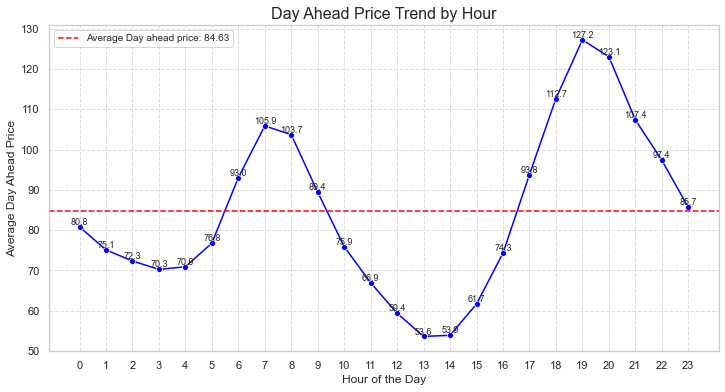

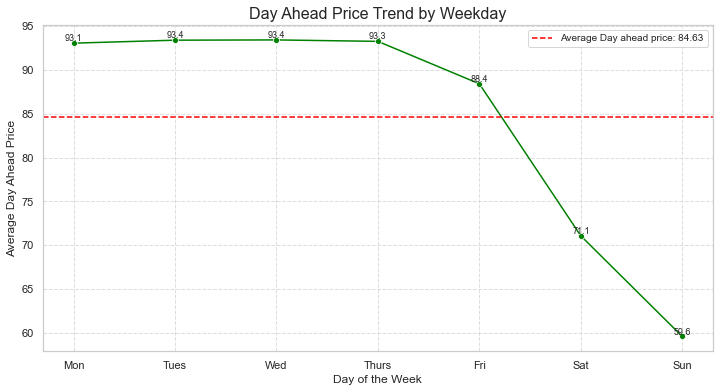

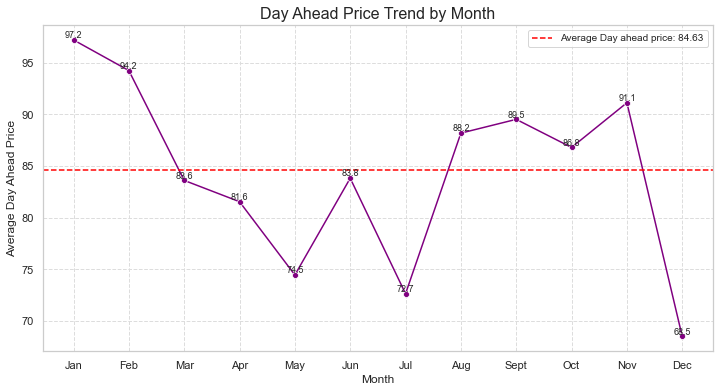

In [31]:
import matplotlib.pyplot as plt

# Grouping data by 'hour', 'week_day', and 'month' to calculate the average 'Day ahead price'
hourly_trend = final_df.groupby('hour')['Day ahead price'].mean()
weekday_trend = final_df.groupby('week_day')['Day ahead price'].mean()
monthly_trend = final_df.groupby('month')['Day ahead price'].mean()

sns.set(style="whitegrid")

# Calculate overall average
overall_avg_price = final_df['Day ahead price'].mean()

# Hourly trend visualization
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='Day ahead price', data=final_df, estimator='mean', ci=None, marker='o', color='blue')
plt.axhline(overall_avg_price, color='red', linestyle='--', label=f'Average Day ahead price: {overall_avg_price:.2f}')
for x, y in hourly_trend.items():
    plt.text(x, y, f'{y:.1f}', fontsize=9, ha='center', va='bottom')
plt.title('Day Ahead Price Trend by Hour', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Average Day Ahead Price', fontsize=12)
plt.xticks(range(0, 24, 1))  # Show every second hour for better readability
plt.legend(fontsize=10)
plt.grid(color='#ddd', linestyle='--')
plt.show()

# Weekday trend visualization
plt.figure(figsize=(12, 6))
sns.lineplot(x='week_day', y='Day ahead price', data=final_df, estimator='mean', ci=None, marker='o', color='green')
plt.axhline(overall_avg_price, color='red', linestyle='--', label=f'Average Day ahead price: {overall_avg_price:.2f}')
for x, y in weekday_trend.items():
    plt.text(x, y, f'{y:.1f}', fontsize=9, ha='center', va='bottom')
plt.title('Day Ahead Price Trend by Weekday', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Average Day Ahead Price', fontsize=12)
plt.xticks(range(7), ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.legend(fontsize=10)
plt.grid(color='#ddd', linestyle='--')
plt.show()

# Monthly trend visualization
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='Day ahead price', data=final_df, estimator='mean', ci=None, marker='o', color='purple')
plt.axhline(overall_avg_price, color='red', linestyle='--', label=f'Average Day ahead price: {overall_avg_price:.2f}')
for x, y in monthly_trend.items():
    plt.text(x, y, f'{y:.1f}', fontsize=9, ha='center', va='bottom')
plt.title('Day Ahead Price Trend by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Day Ahead Price', fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])  # Show months (1-12)
plt.legend(fontsize=10)
plt.grid(color='#ddd', linestyle='--')
plt.show()

In [32]:
# Add daily lag features
for lag in range(1, 25):  # Lag for the past 24 hours
    final_df[f'hourly_lag_{lag}'] = final_df['Day ahead price'].shift(lag)

# Add weekly lag features (7 days ago, same hour)
for lag in range(1, 8):  # Lag for the past 7 days
    final_df[f'weekly_lag_{lag}'] = final_df['Day ahead price'].shift(lag * 24)

# Add monthly lag features (30 days ago, same hour)
for lag in range(1, 2):  # Only 1 monthly lag
    final_df[f'monthly_lag_{lag}'] = final_df['Day ahead price'].shift(lag * 24 * 30)

In [34]:
final_df.isnull().sum()

Biomass                   0
Hydropower                0
Wind offshore             0
Wind onshore              0
Photovoltaics             0
Other renewable           0
Lignite                   0
Hard coal                 0
Fossil gas                0
Hydro pumped storage      0
Other conventional        0
Total Consumption         0
Fcst Total                0
Fcst Other                0
Day ahead price           0
Diffuse radiation         0
Total radiation           0
Sun duration              0
Wind Quality              0
Wind speed                0
Wind direction            0
hour                      0
week_day                  0
month                     0
hourly_lag_1              1
hourly_lag_2              2
hourly_lag_3              3
hourly_lag_4              4
hourly_lag_5              5
hourly_lag_6              6
hourly_lag_7              7
hourly_lag_8              8
hourly_lag_9              9
hourly_lag_10            10
hourly_lag_11            11
hourly_lag_12       

In [37]:
final_df = final_df.fillna(0.00)
final_df.isnull().sum()

Biomass                 0
Hydropower              0
Wind offshore           0
Wind onshore            0
Photovoltaics           0
Other renewable         0
Lignite                 0
Hard coal               0
Fossil gas              0
Hydro pumped storage    0
Other conventional      0
Total Consumption       0
Fcst Total              0
Fcst Other              0
Day ahead price         0
Diffuse radiation       0
Total radiation         0
Sun duration            0
Wind Quality            0
Wind speed              0
Wind direction          0
hour                    0
week_day                0
month                   0
hourly_lag_1            0
hourly_lag_2            0
hourly_lag_3            0
hourly_lag_4            0
hourly_lag_5            0
hourly_lag_6            0
hourly_lag_7            0
hourly_lag_8            0
hourly_lag_9            0
hourly_lag_10           0
hourly_lag_11           0
hourly_lag_12           0
hourly_lag_13           0
hourly_lag_14           0
hourly_lag_1

In [39]:
final_df.describe()

,Biomass,Hydropower,Wind offshore,Wind onshore,Photovoltaics,Other renewable,Lignite,Hard coal,Fossil gas,Hydro pumped storage,...,hourly_lag_23,hourly_lag_24,weekly_lag_1,weekly_lag_2,weekly_lag_3,weekly_lag_4,weekly_lag_5,weekly_lag_6,weekly_lag_7,monthly_lag_1
count,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,...,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000
mean,4231.831960,1865.464975,2765.463801,12862.712666,7247.720457,119.065400,8352.526861,3741.699372,5588.373927,1233.475767,...,84.480165,84.473624,84.473624,84.287496,84.076756,83.910546,83.775142,83.623304,83.455051,80.748434
std,356.413514,401.467134,1850.758181,10031.258464,10738.616089,31.555712,3579.532838,2927.897538,2739.577243,1566.977675,...,46.874271,46.878722,46.878722,46.954584,46.975922,47.070776,47.166957,47.265309,47.341645,49.108473
min,0.000000,0.000000,0.000000,145.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-500.000000,-500.000000,-500.000000,-500.000000,-500.000000,-500.000000,-500.000000,-500.000000,-500.000000,-500.000000
25%,4021.250000,1604.562500,1105.125000,4895.625000,2.250000,96.000000,5203.250000,1724.125000,3378.750000,140.000000,...,61.400000,61.400000,61.400000,61.022500,60.790000,60.560000,60.460000,60.220000,60.010000,55.325000
50%,4214.250000,1879.750000,2557.875000,10121.000000,372.875000,107.000000,8130.500000,2768.625000,5076.250000,481.625000,...,87.520000,87.520000,87.520000,87.365000,87.250000,87.085000,87.060000,87.000000,86.945000,85.815000
75%,4434.187500,2124.500000,4263.125000,18593.875000,12177.437500,140.750000,10980.437500,4850.812500,7201.750000,1802.062500,...,110.200000,110.200000,110.200000,110.090000,110.000000,110.000000,109.990000,109.970000,109.947500,109.167500
max,5167.000000,3113.250000,7633.250000,48023.000000,46848.250000,203.750000,17173.250000,15240.500000,16538.500000,8583.750000,...,656.370000,656.370000,656.370000,656.370000,656.370000,656.370000,656.370000,656.370000,656.370000,656.370000


In [124]:
# Step 2: Feature selection based on correlation
corr_matrix = final_df.corr()
corr_target = corr_matrix["Day ahead price"].drop("Day ahead price")
selected_features = corr_target[abs(corr_target) > 0.0].index.tolist()

In [125]:
selected_features

['Biomass',
 'Hydropower',
 'Wind offshore',
 'Wind onshore',
 'Photovoltaics',
 'Other renewable',
 'Lignite',
 'Hard coal',
 'Fossil gas',
 'Hydro pumped storage',
 'Other conventional',
 'Total Consumption',
 'Fcst Total',
 'Fcst Other',
 'Diffuse radiation',
 'Total radiation',
 'Sun duration',
 'Wind Quality',
 'Wind speed',
 'Wind direction',
 'hour',
 'week_day',
 'month',
 'hourly_lag_1',
 'hourly_lag_2',
 'hourly_lag_3',
 'hourly_lag_4',
 'hourly_lag_5',
 'hourly_lag_6',
 'hourly_lag_7',
 'hourly_lag_8',
 'hourly_lag_9',
 'hourly_lag_10',
 'hourly_lag_11',
 'hourly_lag_12',
 'hourly_lag_13',
 'hourly_lag_14',
 'hourly_lag_15',
 'hourly_lag_16',
 'hourly_lag_17',
 'hourly_lag_18',
 'hourly_lag_19',
 'hourly_lag_20',
 'hourly_lag_21',
 'hourly_lag_22',
 'hourly_lag_23',
 'hourly_lag_24',
 'weekly_lag_1',
 'weekly_lag_2',
 'weekly_lag_3',
 'weekly_lag_4',
 'weekly_lag_5',
 'weekly_lag_6',
 'weekly_lag_7',
 'monthly_lag_1']

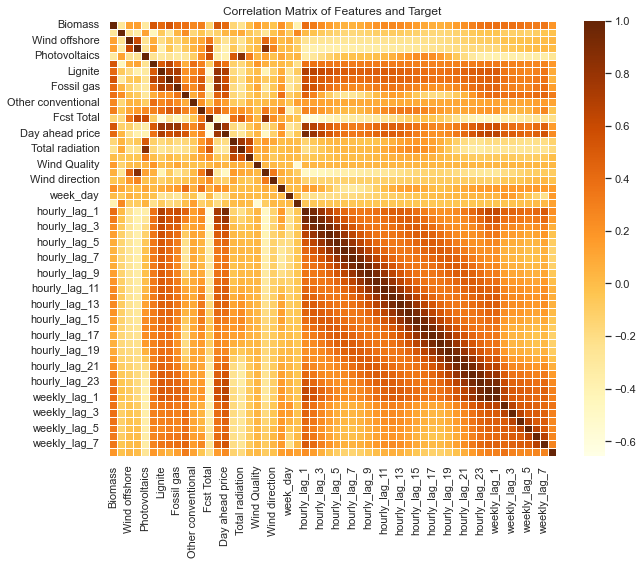

In [126]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap="YlOrBr", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Features and Target")
plt.show()

In [127]:
# Define X (features) and y (target)
X = final_df[selected_features]
y = final_df["Day ahead price"]

In [128]:
last_date = final_df.index[-1].date()

# Identify the date 30 days before the last date
start_test_date = last_date - pd.Timedelta(days=0)

# Select test data: rows within the last 30 days
X_test = X[(final_df.index.date >= start_test_date) & (final_df.index.date <= last_date)]
y_test = y[(final_df.index.date >= start_test_date) & (final_df.index.date <= last_date)]

# Select train data: rows outside the last 30 days
X_train = X[final_df.index.date < start_test_date]
y_train = y[final_df.index.date < start_test_date]

# Confirm the new splits
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16054, 55), (24, 55), (16054,), (24,))

In [129]:
start_test_date

datetime.date(2024, 10, 31)

In [130]:
X_train

,Biomass,Hydropower,Wind offshore,Wind onshore,Photovoltaics,Other renewable,Lignite,Hard coal,Fossil gas,Hydro pumped storage,...,hourly_lag_23,hourly_lag_24,weekly_lag_1,weekly_lag_2,weekly_lag_3,weekly_lag_4,weekly_lag_5,weekly_lag_6,weekly_lag_7,monthly_lag_1
Start date,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,4365.00,1275.25,3059.25,28710.50,1.25,129.50,3859.25,2067.50,1721.75,42.75,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2023-01-01 01:00:00,4344.75,1226.50,3586.00,29305.00,1.00,129.00,3866.50,2052.00,1568.00,126.75,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2023-01-01 02:00:00,4333.00,1222.50,3842.25,29266.00,1.25,129.00,3860.25,2034.25,1571.50,85.50,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2023-01-01 03:00:00,4338.75,1223.25,3463.25,27008.50,1.00,129.00,3864.75,2037.00,1564.75,84.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2023-01-01 04:00:00,4353.25,1244.00,3462.25,26438.75,1.50,128.25,3841.00,2040.25,1550.50,84.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-30 19:00:00,4489.75,1987.75,1552.25,4689.25,0.00,86.25,12781.50,7216.00,10881.00,3294.50,...,140.60,203.82,203.82,146.12,130.47,118.74,184.85,114.19,177.60,64.24
2024-10-30 20:00:00,4485.25,1745.00,1501.25,4592.50,0.00,85.00,12389.75,7086.25,10179.00,1595.00,...,124.05,140.60,140.60,124.19,118.15,96.48,123.86,96.61,111.71,42.35
2024-10-30 21:00:00,4475.75,1676.25,1453.25,4419.25,0.00,85.00,12266.00,6899.75,9227.75,434.25,...,118.08,124.05,124.05,115.59,112.01,88.76,116.29,93.64,101.51,21.93


In [131]:
# Step 3: Train and evaluate multiple models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

In [132]:
performance_metrics = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    performance_metrics.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2})

In [133]:
performance_metrics

[{'Model': 'Linear Regression',
  'MAE': 4.864404781118768,
  'RMSE': 5.738301175309072,
  'R2': 0.8928587815345973},
 {'Model': 'Random Forest',
  'MAE': 4.2107041666666625,
  'RMSE': 6.200105567616032,
  'R2': 0.8749199424312979},
 {'Model': 'Gradient Boosting',
  'MAE': 3.866224794398272,
  'RMSE': 5.487578056563321,
  'R2': 0.9020168661366063}]

### predicting with the best model

In [134]:
# Define the model
model = GradientBoostingRegressor(random_state=42)

# Define the parameter grid
param_distributions = {
    'n_estimators': [150],
    'learning_rate': [0.05, 1.0],
    'max_depth': [5],
    'subsample': [0.8],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Define the scoring metric (MAE in this case)
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=50,  # Number of combinations to try
    scoring=scorer,
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Perform the search
random_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Evaluate the model on the test set
best_model = random_search.best_estimator_
test_predictions = best_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, test_predictions)
print(f"MAE on Test Set: {mae}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.05}
MAE on Test Set: 3.480123184530058


In [135]:
# As we can notice from the performance metrics of different models used. 
# Considering the errors to reduce between Actual price and Predicted price, let's take MAE to judge the best model to test.

# So, let's test with Ridge Regression as it gave the least MAE.

model_gbr = GradientBoostingRegressor(random_state=42, subsample=0.8, n_estimators=150, min_samples_split=2, 
                                      min_samples_leaf=2, max_depth=5, learning_rate=0.05)
model_gbr.fit(X_train, y_train)
y1_pred = model_gbr.predict(X_test)

In [136]:
# Creating a DataFrame to store the results
last_day_results = pd.DataFrame({
    "Date-Time": X_test.index,
    "Actual Price": y_test.values,
    "Predicted Price": y1_pred
})

# Resetting the index for better readability
last_day_results.set_index("Date-Time", inplace=True)
last_day_results.index = pd.to_datetime(last_day_results.index)

last_day_results.sort_index()

last_day_results

,Actual Price,Predicted Price
Date-Time,,
2024-10-31 00:00:00,105.16,105.195481
2024-10-31 01:00:00,98.51,101.085184
2024-10-31 02:00:00,96.58,96.077065
2024-10-31 03:00:00,94.81,94.106693
2024-10-31 04:00:00,98.03,93.796345
2024-10-31 05:00:00,102.34,100.093560
2024-10-31 06:00:00,121.15,114.093922
2024-10-31 07:00:00,135.53,133.321265
2024-10-31 08:00:00,133.47,133.889352


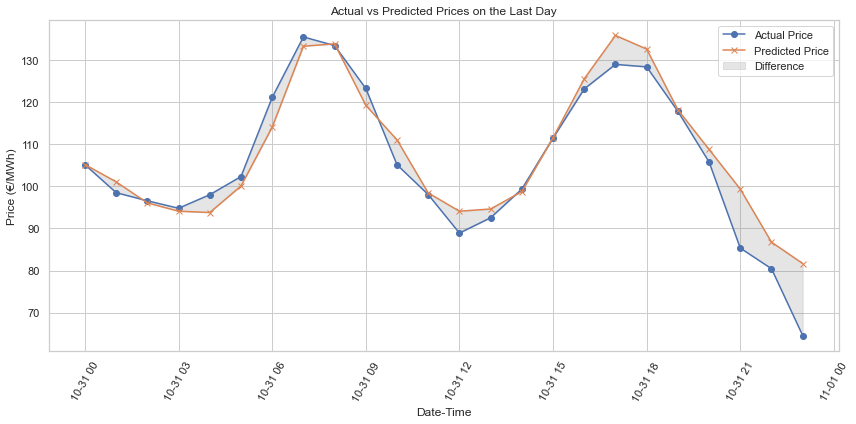

In [137]:
plt.figure(figsize=(12, 6))
plt.plot(last_day_results.index, last_day_results["Actual Price"], label="Actual Price", marker='o')
plt.plot(last_day_results.index, last_day_results["Predicted Price"], label="Predicted Price", marker='x')
plt.fill_between(
    last_day_results.index,
    last_day_results["Actual Price"],
    last_day_results["Predicted Price"],
    color='gray',
    alpha=0.2,
    label="Difference"
)
plt.title("Actual vs Predicted Prices on the Last Day")
plt.xlabel("Date-Time")
plt.ylabel("Price (€/MWh)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

## TO DO Ideas

* <b>[ In Process ]</b> Check the summary and trend of individual features to dig more on the seasonality. 

* <b>[ In Process ]</b> Create Lag features and rolling means (Feature Engineering) for better modeling.

* Include other datasets like balancing and costs, but after the understanding of its importance in the market prices.

* <b>[ Pending Data ]</b> Gather Weather data, if possible, in hourly basis to merge with our datasets.

In [138]:
# Prepare features for Nov 1, 2024
nov_1_features = final_df.loc["2024-10-31 00:00:00":"2024-10-31 23:00:00"]
nov_1_features = nov_1_features.drop(columns=['Day ahead price'])

In [139]:
# Predict for Nov 1, 2024
nov_1_predictions = model_gbr.predict(nov_1_features)

# Prepare a DataFrame for results
nov_1_results = pd.DataFrame({
    'Date-Time': pd.date_range(start="2024-11-01 00:00:00", end="2024-11-01 23:00:00", freq='H'),
    'Predicted Price': nov_1_predictions
})

print("Predictions for Nov 1, 2024:")
print(nov_1_results)


Predictions for Nov 1, 2024:
             Date-Time  Predicted Price
0  2024-11-01 00:00:00       105.195481
1  2024-11-01 01:00:00       101.085184
2  2024-11-01 02:00:00        96.077065
3  2024-11-01 03:00:00        94.106693
4  2024-11-01 04:00:00        93.796345
5  2024-11-01 05:00:00       100.093560
6  2024-11-01 06:00:00       114.093922
7  2024-11-01 07:00:00       133.321265
8  2024-11-01 08:00:00       133.889352
9  2024-11-01 09:00:00       119.272333
10 2024-11-01 10:00:00       111.058765
11 2024-11-01 11:00:00        98.448470
12 2024-11-01 12:00:00        94.103610
13 2024-11-01 13:00:00        94.636336
14 2024-11-01 14:00:00        98.765395
15 2024-11-01 15:00:00       111.568147
16 2024-11-01 16:00:00       125.589157
17 2024-11-01 17:00:00       135.879263
18 2024-11-01 18:00:00       132.637619
19 2024-11-01 19:00:00       118.217616
20 2024-11-01 20:00:00       108.786009
21 2024-11-01 21:00:00        99.363909
22 2024-11-01 22:00:00        86.747875
23 2024-11-

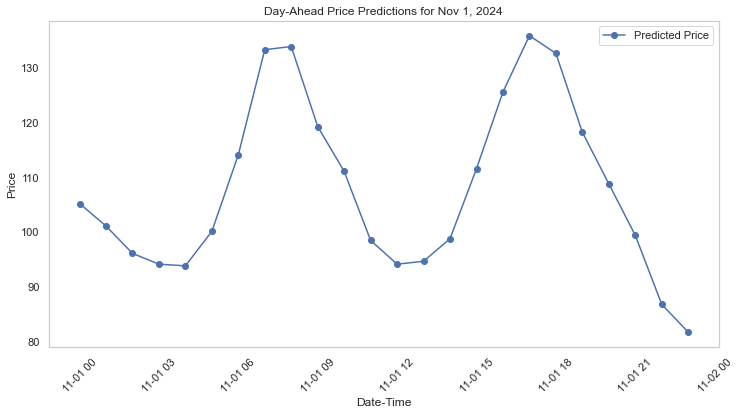

In [140]:
# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(nov_1_results['Date-Time'], nov_1_results['Predicted Price'], label='Predicted Price', marker='o')
plt.title('Day-Ahead Price Predictions for Nov 1, 2024')
plt.xlabel('Date-Time')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [73]:
nov_1_features

,Biomass,Hydropower,Wind offshore,Wind onshore,Photovoltaics,Other renewable,Lignite,Hard coal,Fossil gas,Hydro pumped storage,...,hourly_lag_23,hourly_lag_24,weekly_lag_1,weekly_lag_2,weekly_lag_3,weekly_lag_4,weekly_lag_5,weekly_lag_6,weekly_lag_7,monthly_lag_1
Start date,,,,,,,,,,,,,,,,,,,,,
2024-10-31 00:00:00,4330.00,1666.00,2573.50,4853.25,0.00,84.00,10238.50,5355.00,4842.75,104.25,...,100.52,100.71,100.71,101.34,95.60,92.22,115.29,82.50,91.75,3.21
2024-10-31 01:00:00,4280.75,1600.75,2797.25,5241.75,0.00,84.00,10208.75,5297.75,4028.00,3.50,...,98.16,100.52,100.52,100.04,94.37,84.00,109.64,82.07,82.42,0.07
2024-10-31 02:00:00,4246.75,1673.25,3005.75,5350.75,0.00,83.25,10191.75,5277.50,3908.75,5.00,...,98.05,98.16,98.16,98.83,88.74,81.33,106.95,79.69,80.67,0.05
2024-10-31 03:00:00,4222.50,1634.00,3945.50,5553.00,0.00,81.00,10157.00,5182.00,3810.00,55.25,...,100.56,98.05,98.05,98.17,84.09,79.41,107.79,82.60,80.29,0.02
2024-10-31 04:00:00,4237.00,1608.75,3902.50,5923.00,0.00,82.00,10155.75,4922.00,3914.75,18.00,...,106.32,100.56,100.56,100.02,86.26,78.79,105.70,84.47,80.45,0.09
2024-10-31 05:00:00,4287.50,1686.50,3596.50,6158.75,0.00,85.00,11068.00,5250.25,4621.75,213.00,...,123.54,106.32,106.32,113.10,99.93,85.14,106.82,94.59,83.82,6.80
2024-10-31 06:00:00,4380.75,2050.25,3321.00,6090.50,6.25,85.00,12322.25,5458.00,5346.50,1398.00,...,139.68,123.54,123.54,127.38,109.92,89.21,113.93,108.94,103.21,63.96
2024-10-31 07:00:00,4456.00,2028.75,3452.50,6111.75,455.00,85.00,12362.75,5342.00,6285.25,3756.00,...,138.91,139.68,139.68,157.73,130.01,88.05,125.71,123.75,148.29,103.35
2024-10-31 08:00:00,4501.25,2050.00,3958.00,6763.50,2318.50,85.00,12088.50,5084.25,6909.75,3193.00,...,124.34,138.91,138.91,151.32,127.38,84.34,126.00,150.59,171.27,114.98
